Since your task involves **Applied Machine Learning**, let’s break it down into clear steps:

### **1. Understanding the Dataset**
- Load the dataset
- Check for missing values (even though we know there are none)
- Explore basic statistics (mean, standard deviation, etc.)
- Visualize distributions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB
None
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    

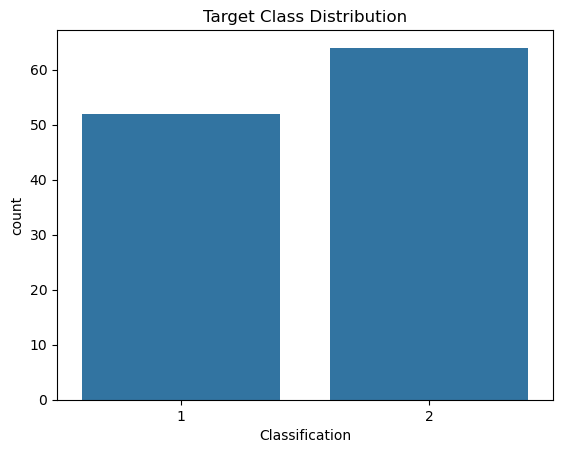

Missing values per column:
 Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "dataR2.csv"  # Adjust this if running locally
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.describe())

# Check class distribution
sns.countplot(x="Classification", data=df)
plt.title("Target Class Distribution")
plt.show()

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())


### **2. Preprocessing**
- Encode the target variable (convert 1/2 into 0/1 for binary classification)
- Scale the features (important for algorithms like logistic regression, SVM, and neural networks)
- Split data into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode the target variable (1 -> 0, 2 -> 1)
df["Classification"] = df["Classification"].map({1: 0, 2: 1})

# Separate features and target
X = df.drop(columns=["Classification"])
y = df["Classification"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


### **3. Applying Machine Learning**
- Train baseline models (e.g., Logistic Regression, Decision Tree, Random Forest, SVM, etc.)
- Evaluate performance using accuracy, precision, recall, F1-score
- Tune hyperparameters with GridSearchCV or RandomizedSearchCV

### **4. Feature Selection & Engineering**
- Check feature importance using techniques like mutual information or correlation
- Try PCA (Principal Component Analysis) if dimensionality reduction is needed

### **5. Model Evaluation & Interpretation**
- Use confusion matrix, ROC curve, and classification reports
- Explain predictions using SHAP or LIME